In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

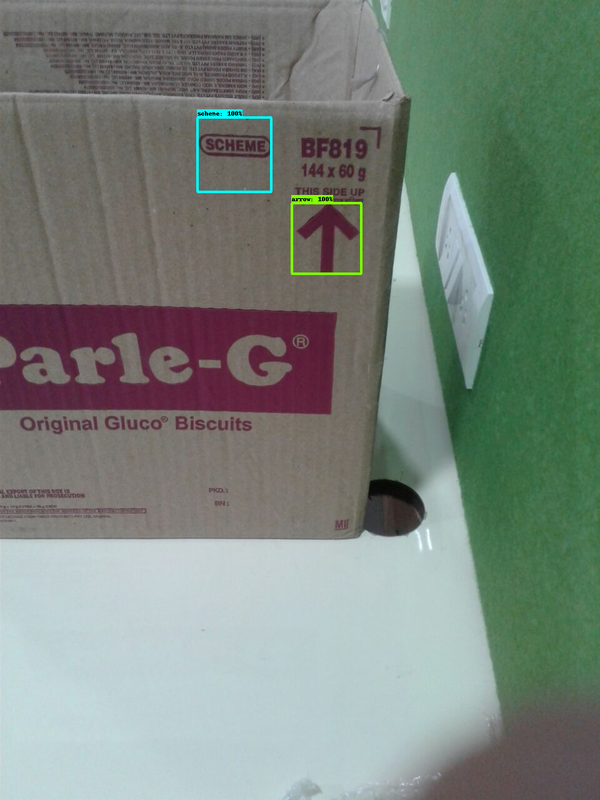

In [2]:
file_name = '/Users/cosmos/Desktop/parleg-alpha/RealTimeObjectDetection/output.png'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [3]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [4]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)


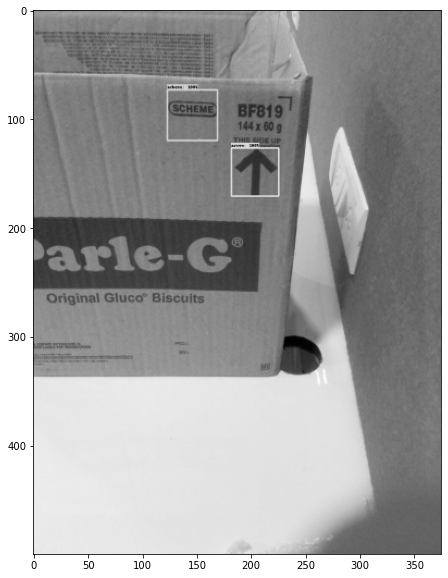

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

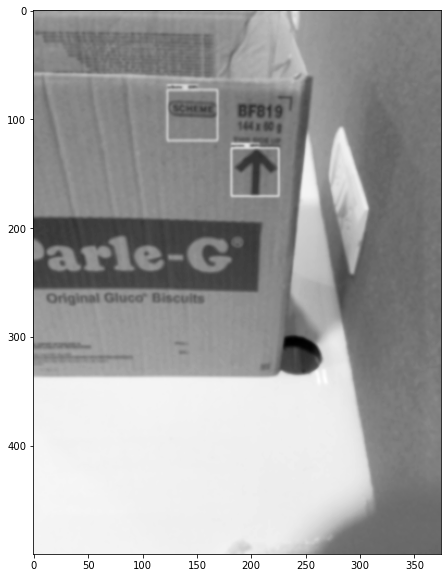

In [6]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

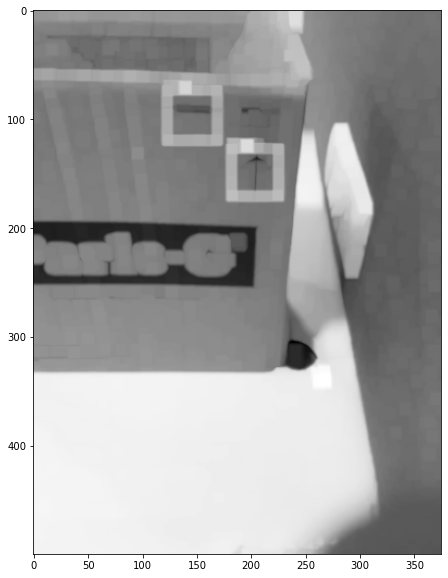

In [7]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

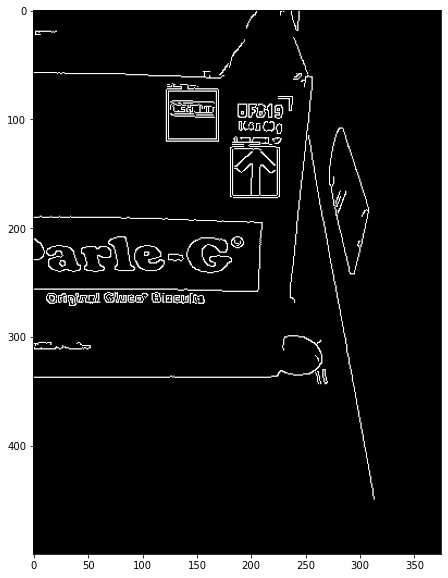

In [8]:
edged = cv2.Canny(gray, 100, 200, apertureSize=3)
plot_gray(edged)

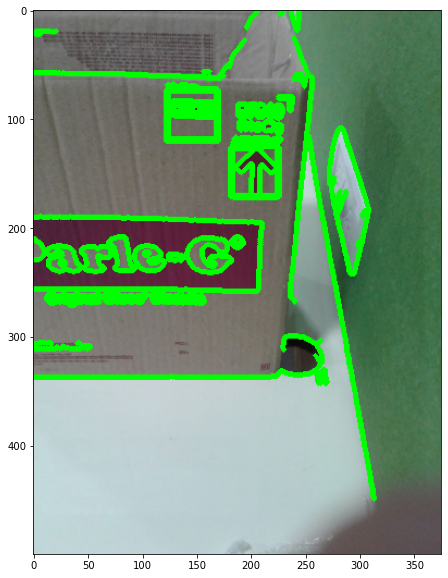

In [19]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

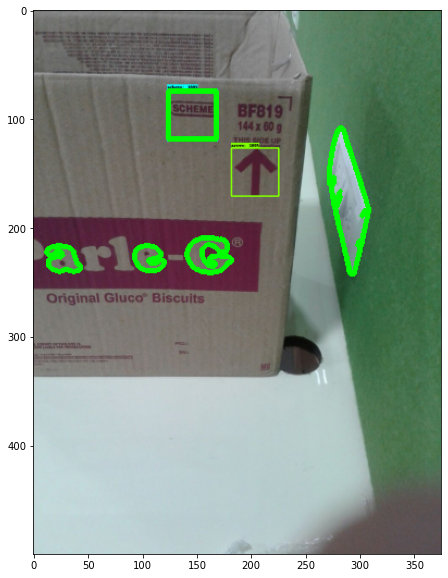

In [20]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [21]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_box(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [22]:
get_box(largest_contours)

array([[[281, 108]],

       [[272, 160]],

       [[295, 242]],

       [[308, 181]]], dtype=int32)

In [23]:
receipt_contour = get_box(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)

def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

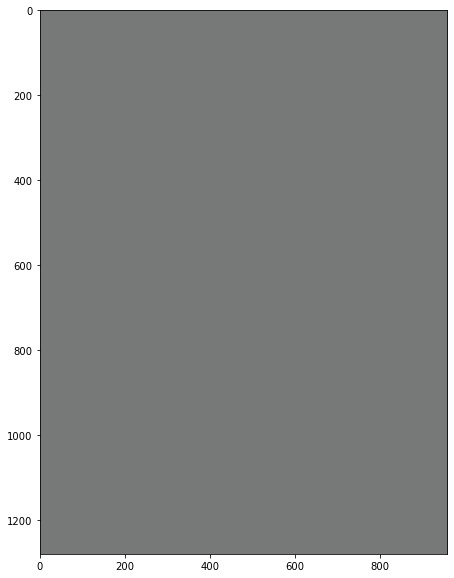

In [24]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

# OCR

In [15]:
scanned #an array 

array([[[119, 121, 121],
        [119, 121, 121],
        [119, 121, 121],
        ...,
        [119, 121, 121],
        [119, 121, 121],
        [119, 121, 121]],

       [[119, 121, 121],
        [119, 121, 121],
        [119, 121, 121],
        ...,
        [119, 121, 121],
        [119, 121, 121],
        [119, 121, 121]],

       [[119, 121, 121],
        [119, 121, 121],
        [119, 121, 121],
        ...,
        [119, 121, 121],
        [119, 121, 121],
        [119, 121, 121]],

       ...,

       [[119, 121, 121],
        [119, 121, 121],
        [119, 121, 121],
        ...,
        [119, 121, 121],
        [119, 121, 121],
        [119, 121, 121]],

       [[119, 121, 121],
        [119, 121, 121],
        [119, 121, 121],
        ...,
        [119, 121, 121],
        [119, 121, 121],
        [119, 121, 121]],

       [[119, 121, 121],
        [119, 121, 121],
        [119, 121, 121],
        ...,
        [119, 121, 121],
        [119, 121, 121],
        [119, 121, 121]]

In [16]:
type(images)

NameError: name 'images' is not defined

Text(0.5, 1.0, 'First Image')

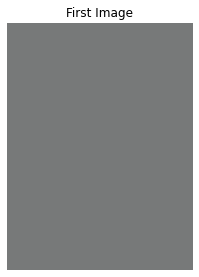

In [17]:
fig = plt.figure(figsize=(16,10))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(scanned)
plt.axis('off')
plt.title("First Image")

In [28]:
import keras_ocr

images = keras_ocr.tools.read('/Users/cosmos/Desktop/ME/Parle-G Project/TrainingPhots-parle G/photo_2022-04-08_13-36-36.jpg')

pipline = keras_ocr.pipeline.Pipeline() #Creting a pipline 
kerasocr_preds = pipline.recognize(images)

In [ ]:
#keras OCR
fig,axs = plt.subplots(nrows = 4 , figsize = (30,30))
for ax , image,  prediction in zip(axs , scanned , kerasocr_preds):
    keras_ocr.tools.drawAnnotations(image, prediction, ax)

In [33]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import easyocr

text_reader = easyocr.Reader(['en']) #Initialzing the ocr

results = text_reader.readtext(scanned)
for (bbox, text, prob) in results:
    print(text)
plt.imshow(scanned)
plt.title("First Image")